In [1]:
# -----------------
# Import and Setup
# -----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model

# Stonks Meme Aesthetic
plt.style.use("dark_background")
STONKS_GREEN = '#00ff9c'
STONKS_RED   = '#ff005c'
STONKS_BLUE  = '#00c3ff'
STONKS_PURP  = '#9d4edd'

FIG_DIR = Path("../figures")
FIG_DIR.mkdir(exist_ok=True)

# Load the Data
df = pd.read_csv("../Neural Network for Volatility Forecasting/data/processed/features.csv", index_col=0, parse_dates=True)

df.head()

C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


,returns,rv_5,rv_21,bonds,curve_slope,target_vol
2016-03-16,0.005585,0.120164,0.146579,1.94,1.94,0.116551
2016-03-17,0.006574,0.116551,0.139259,1.91,1.91,0.062748
2016-03-18,0.004396,0.062748,0.136701,1.88,1.88,0.055433
2016-03-21,0.000985,0.055433,0.136448,1.92,1.92,0.050165
2016-03-22,-0.000878,0.050165,0.130868,1.94,1.94,0.079752


In [3]:
# ----------------------
# Baseline Models Setup
# ----------------------

# Features
returns = df["returns"]
realized_vol = df["target_vol"]

# Naive Model
df["naive_vol"] = df["rv_5"].shift(0)

# Rolling Historic
df["hist_vol_21"] = returns.rolling(21).std() * np.sqrt(252)

# EWMA
lambda_ = 0.94

ewma_var = []
var = returns.var()

for r in returns:
    var = lambda_ * var + (1 - lambda_) * r**2
    ewma_var.append(var)

df["ewma_vol"] = np.sqrt(ewma_var) * np.sqrt(252)

# Garch(1,1)
am = arch_model(returns * 100, vol="GARCH", p=1, q=1)
res = am.fit(disp="off")

df["garch_vol"] = res.conditional_volatility / 100 * np.sqrt(252)

# Prediction Alignment
models = [
    "naive_vol",
    "hist_vol_21",
    "ewma_vol",
    "garch_vol"
]

eval_df = df.dropna(subset=models + ["target_vol"])

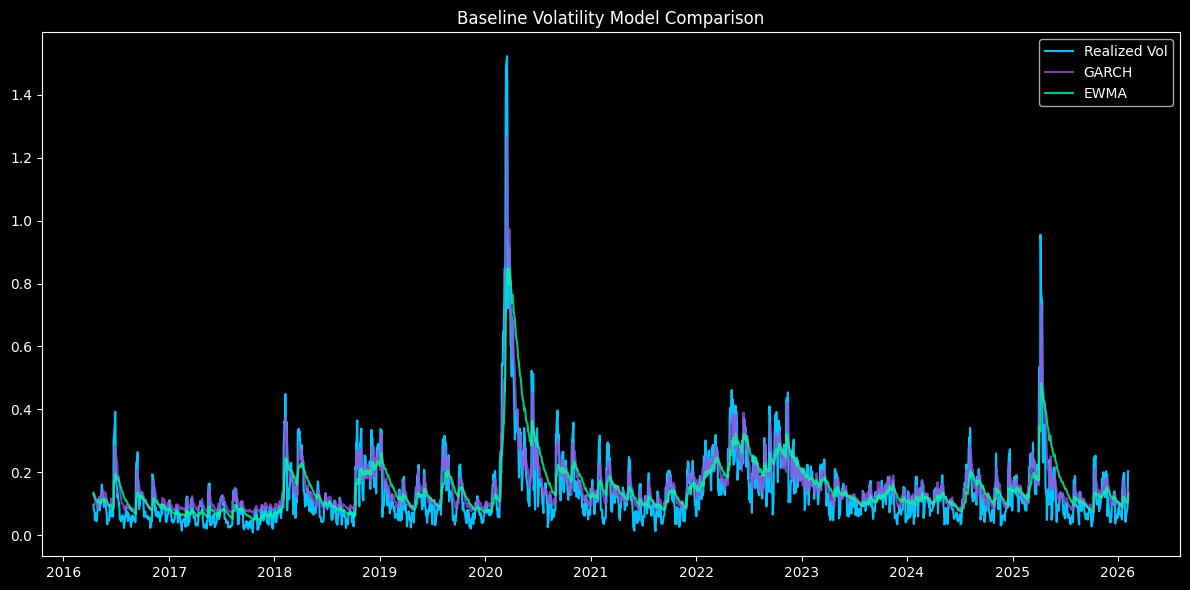

In [5]:
# -----------------
# Model Comparison
# -----------------

plt.figure(figsize=(12,6))
plt.plot(eval_df["target_vol"], label="Realized Vol", color=STONKS_BLUE)
plt.plot(eval_df["garch_vol"], label="GARCH", color=STONKS_PURP, alpha=0.8)
plt.plot(eval_df["ewma_vol"], label="EWMA", color=STONKS_GREEN, alpha=0.8)

plt.legend()
plt.title("Baseline Volatility Model Comparison")
plt.tight_layout()
plt.savefig(FIG_DIR / "baseline_vol_comparison.png", dpi=150)
plt.show()

In [7]:
# Error Metrics

results = {}

for model in models:
    mse = mean_squared_error(eval_df["target_vol"], eval_df[model])
    mae = mean_absolute_error(eval_df["target_vol"], eval_df[model])
    
    results[model] = {
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "MAE": mae
    }

results_df = pd.DataFrame(results).T.sort_values("RMSE")
results_df

,MSE,RMSE,MAE
naive_vol,0.002029,0.045049,0.025035
garch_vol,0.003528,0.059394,0.041313
ewma_vol,0.006101,0.078109,0.051757
hist_vol_21,0.006747,0.082141,0.051840


In [11]:
# Baseline Results

results_df.to_csv("../Neural Network for Volatility Forecasting/results/baseline_model_metrics.csv")
eval_df.to_csv("../Neural Network for Volatility Forecasting/data/processed/baseline_predictions.csv")